<a href="https://colab.research.google.com/github/Swayamprakashpatel/Sol_ME/blob/main/GNN_Solubility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10, Train Loss: 6376.8135, Val Loss: 7186.8679, Val RMSE: 84.7754
Epoch 2/10, Train Loss: 5989.5268, Val Loss: 6969.4384, Val RMSE: 83.4832
Epoch 3/10, Train Loss: 6024.0824, Val Loss: 6994.5837, Val RMSE: 83.6336
Epoch 4/10, Train Loss: 6165.1692, Val Loss: 7074.5740, Val RMSE: 84.1105
Epoch 5/10, Train Loss: 6231.1431, Val Loss: 7131.7507, Val RMSE: 84.4497
Epoch 6/10, Train Loss: 6160.2841, Val Loss: 6981.9897, Val RMSE: 83.5583
Epoch 7/10, Train Loss: 6027.8339, Val Loss: 6998.8678, Val RMSE: 83.6592
Epoch 8/10, Train Loss: 6084.5462, Val Loss: 7012.0528, Val RMSE: 83.7380
Epoch 9/10, Train Loss: 6013.3424, Val Loss: 7025.0486, Val RMSE: 83.8156
Epoch 10/10, Train Loss: 6061.9345, Val Loss: 6961.5133, Val RMSE: 83.4357
Predictions: [50.614895 49.055607 49.883305 48.8251   49.98508  48.744984 50.111744
 52.764194 49.40534  52.576508 49.597996 49.659603 48.114155 49.02664
 49.455524 50.401127 49.08854  48.466175 48.39814  51.003986 49.558987
 48.761    52.092674 49.769363 48.

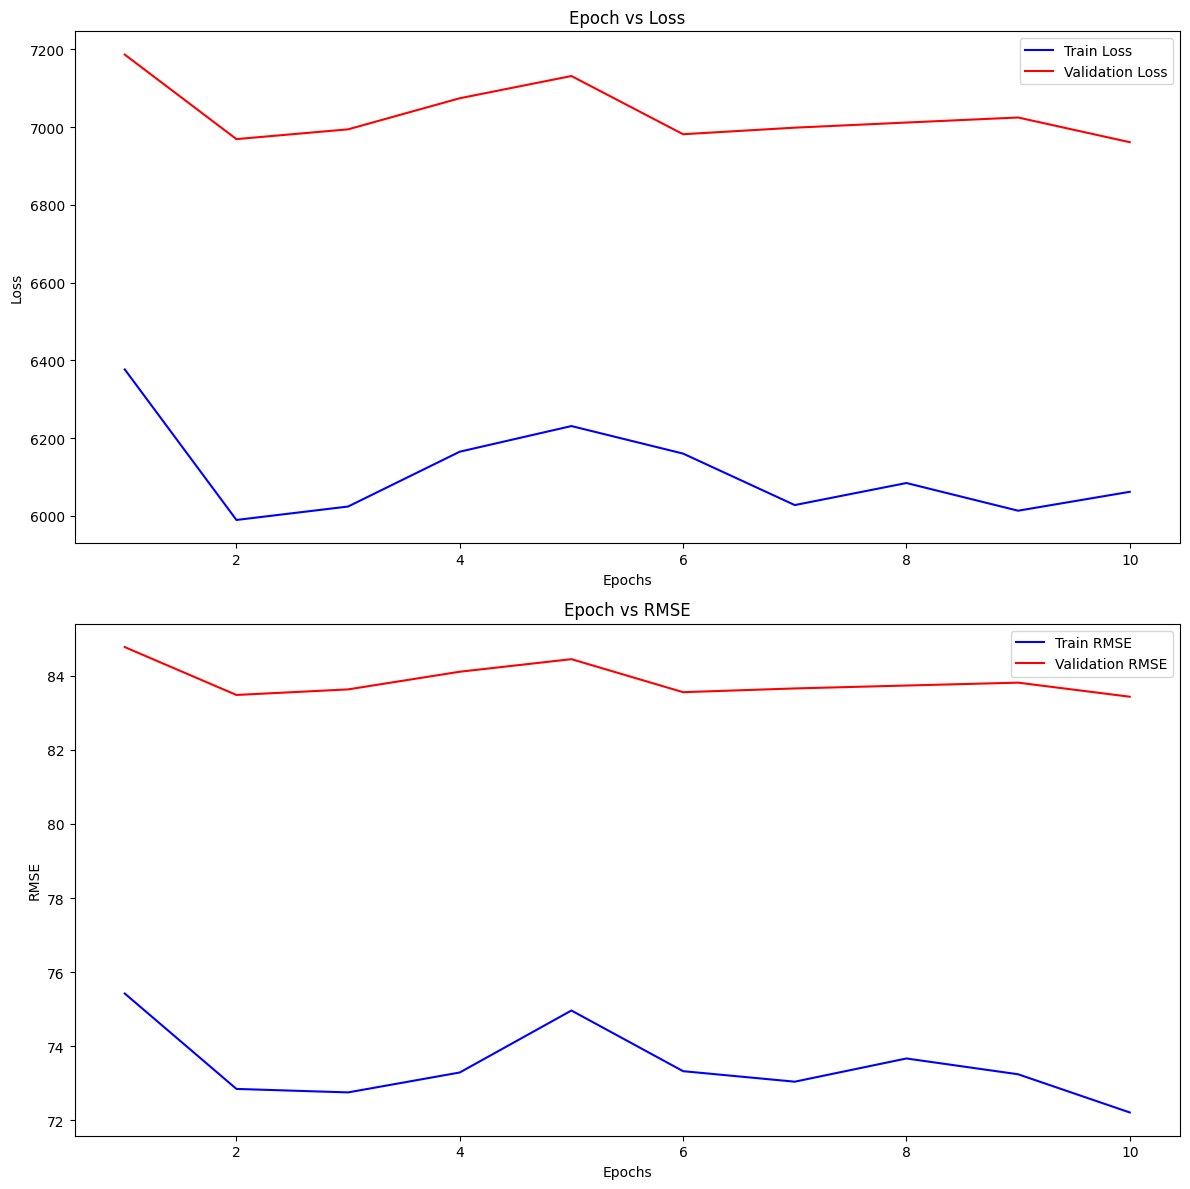

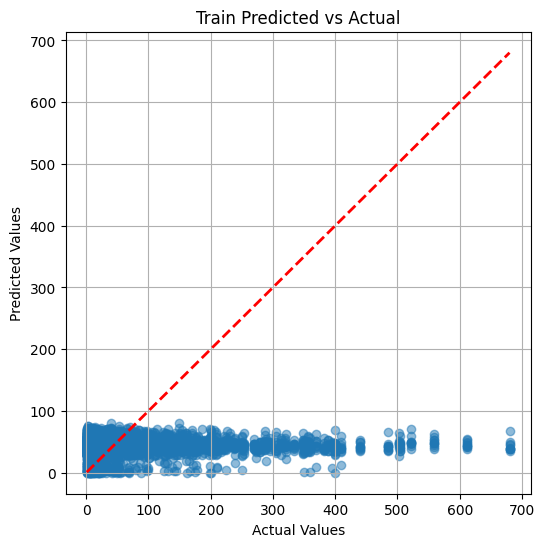

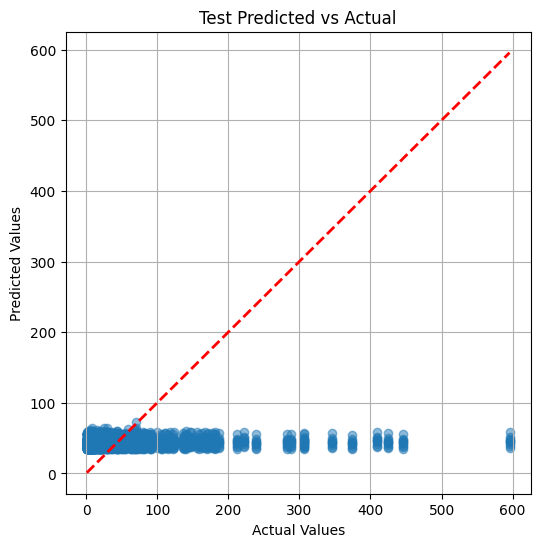

In [14]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from rdkit import Chem
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/content/GNN_Smiles.csv')

# Define a function to convert SMILES to graph data
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    edges = []
    for bond in mol.GetBonds():
        edges.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.float).view(-1, 1)
    return Data(x=x, edge_index=edge_index)

# Convert SMILES to graph data
drug_graphs = [smiles_to_graph(smiles) for smiles in data['Drug_Smile']]
solvent_graphs = [smiles_to_graph(smiles) for smiles in data['Solvent_Smile']]

# Combine drug and solvent graphs
def combine_graphs(drug_graph, solvent_graph):
    x = torch.cat([drug_graph.x, solvent_graph.x], dim=0)
    edge_index = torch.cat([drug_graph.edge_index, solvent_graph.edge_index + drug_graph.x.size(0)], dim=1)
    return Data(x=x, edge_index=edge_index)

graphs = [combine_graphs(drug, solvent) for drug, solvent in zip(drug_graphs, solvent_graphs)]
labels = torch.tensor(data['Solubility'].values, dtype=torch.float)

# Prepare the dataset
train_graphs, test_graphs, train_labels, test_labels = train_test_split(graphs, labels, test_size=0.2, random_state=42)

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(1, 64)
        self.conv2 = GCNConv(64, 128)
        self.fc = torch.nn.Linear(128, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)
        return x

# Define early stopping and model checkpointing based on RMSE
class EarlyStopping:
    def __init__(self, patience=15, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_rmse = float('inf')
        self.wait = 0
        self.stop = False

    def __call__(self, val_rmse):
        if val_rmse < self.best_rmse - self.delta:
            self.best_rmse = val_rmse
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop = True

early_stopping = EarlyStopping(patience=15, delta=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Initialize lists to store metrics and predictions
train_losses = []
val_losses = []
val_rmse_list = []
train_predictions = []
train_actuals = []
test_predictions = []
test_actuals = []
train_rmse_list = []

# Create data loaders
def collate_fn(data_list):
    graphs, labels = zip(*data_list)
    batch = Data.from_data_list(graphs)
    return batch, torch.tensor(labels, dtype=torch.float)

train_loader = DataLoader(list(zip(train_graphs, train_labels)), batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(list(zip(test_graphs, test_labels)), batch_size=32, shuffle=False, collate_fn=collate_fn)

# Define functions for training and validation
def train():
    model.train()
    total_loss = 0
    total_rmse = 0
    for batch_graph, batch_labels in train_loader:
        batch_graph = batch_graph.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        out = model(batch_graph)
        loss = criterion(out.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        rmse = np.sqrt(loss.item())
        total_rmse += rmse

        # Collect training predictions
        train_predictions.extend(out.cpu().detach().numpy())
        train_actuals.extend(batch_labels.cpu().numpy())

    avg_rmse = total_rmse / len(train_loader)
    train_rmse_list.append(avg_rmse)

    return total_loss / len(train_loader)

def validate():
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_graph, batch_labels in test_loader:
            batch_graph = batch_graph.to(device)
            batch_labels = batch_labels.to(device)
            out = model(batch_graph)
            loss = criterion(out.squeeze(), batch_labels)
            val_loss += loss.item()

            # Collect test predictions
            test_predictions.extend(out.cpu().detach().numpy())
            test_actuals.extend(batch_labels.cpu().numpy())

    rmse = np.sqrt(val_loss / len(test_loader))
    return val_loss / len(test_loader), rmse

# Training loop with early stopping and model checkpointing based on RMSE
num_epochs = 10
best_rmse = float('inf')

for epoch in range(num_epochs):
    train_loss = train()
    val_loss, val_rmse = validate()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_rmse_list.append(val_rmse)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}')

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model checkpoint

    early_stopping(val_rmse)
    if early_stopping.stop:
        print('Early stopping triggered.')
        break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

# Evaluate the model
model.eval()
predictions = []
with torch.no_grad():
    for batch_graph, _ in test_loader:
        batch_graph = batch_graph.to(device)
        pred = model(batch_graph)
        predictions.extend(pred.cpu().numpy())
predictions = np.concatenate(predictions)

print("Predictions:", predictions)
print("True Labels:", np.array(test_actuals))

# Plotting the metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 12))

# Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

# Training and Validation RMSE
plt.subplot(2, 1, 2)
plt.plot(epochs, train_rmse_list, 'b', label='Train RMSE')
plt.plot(epochs, val_rmse_list, 'r', label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Epoch vs RMSE')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Predicted vs Actual (Train)
if train_actuals and train_predictions:
    plt.figure(figsize=(6, 6))
    train_predictions = np.array(train_predictions)
    train_actuals = np.array(train_actuals)
    plt.scatter(train_actuals, train_predictions, alpha=0.5)
    plt.plot([train_actuals.min(), train_actuals.max()], [train_actuals.min(), train_actuals.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Train Predicted vs Actual')
    plt.grid(True)
    plt.show()

# Plot Predicted vs Actual (Test)
if test_actuals and test_predictions:
    plt.figure(figsize=(6, 6))
    test_predictions = np.array(test_predictions)
    test_actuals = np.array(test_actuals)
    plt.scatter(test_actuals, test_predictions, alpha=0.5)
    plt.plot([test_actuals.min(), test_actuals.max()], [test_actuals.min(), test_actuals.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Test Predicted vs Actual')
    plt.grid(True)
    plt.show()
